In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import torch
from torch import nn


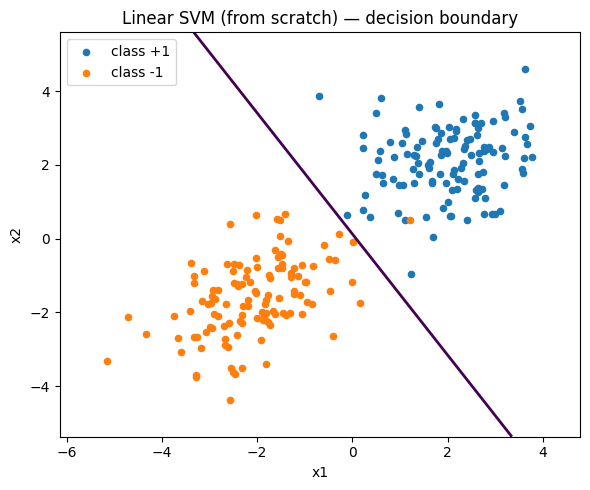

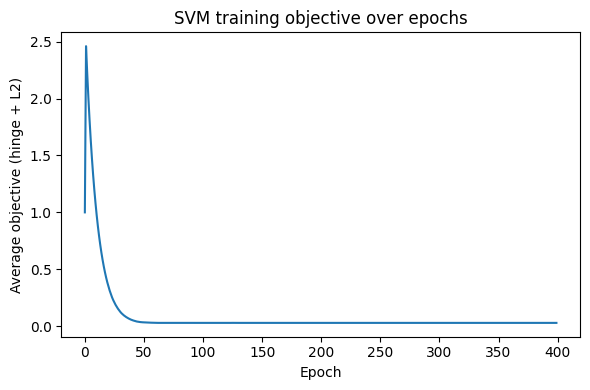

In [8]:
# 產生 2D toy data
np.random.seed(42)
n_per_class = 120
mean_pos = np.array([2.0, 2.0])
mean_neg = np.array([-2.0, -1.5])
cov = np.array([[1.0, 0.3],[0.3, 1.0]])

X_pos = np.random.multivariate_normal(mean_pos, cov, n_per_class)
X_neg = np.random.multivariate_normal(mean_neg, cov, n_per_class)
X = np.vstack([X_pos, X_neg])             # shape: (240, 2)
y = np.hstack([np.ones(n_per_class), -np.ones(n_per_class)])  # labels in {+1, -1}

# 線性 SVM (hinge loss + L2) 的 batch GD；同時記錄 loss
def svm_train_hinge_with_history(X, y, C=1.0, lr=5e-2, epochs=400):
    n, d = X.shape
    w = np.zeros(d); b = 0.0
    losses = []
    for _ in range(epochs):
        margins = y * (X @ w + b)
        mask = margins < 1  # 只有違反間隔的樣本會貢獻 hinge 梯度
        # 次梯度
        grad_w = w - C * (X[mask].T @ y[mask])
        grad_b = - C * np.sum(y[mask])
        # 目標值（平均）：0.5||w||^2 + C * sum(hinge)
        hinge = np.maximum(0.0, 1 - margins)
        J = 0.5*np.dot(w, w) + C*np.sum(hinge)
        losses.append(J / n)
        w = w + (-lr * grad_w)
        b = b + (-lr * grad_b)
    return w, b, np.array(losses)

w, b, loss_hist = svm_train_hinge_with_history(X, y)

# 決策邊界
xmin, xmax = X[:,0].min()-1.0, X[:,0].max()+1.0
ymin, ymax = X[:,1].min()-1.0, X[:,1].max()+1.0
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300), np.linspace(ymin, ymax, 300))
ZZ = w[0]*xx + w[1]*yy + b

plt.figure(figsize=(6,5))
plt.contour(xx, yy, ZZ, levels=[0], linewidths=2)
plt.scatter(X_pos[:,0], X_pos[:,1], s=20, label="class +1")
plt.scatter(X_neg[:,0], X_neg[:,1], s=20, label="class -1")
plt.title("Linear SVM (from scratch) — decision boundary")
plt.xlabel("x1"); plt.ylabel("x2"); plt.legend(); plt.tight_layout()
plt.show()

# 訓練目標值（hinge + L2）曲線
plt.figure(figsize=(6,4))
plt.plot(loss_hist)
plt.xlabel("Epoch"); plt.ylabel("Average objective (hinge + L2)")
plt.title("SVM training objective over epochs")
plt.tight_layout(); plt.show()
